### <span style='color:blue '> Projet 5,  Segmentation des clients du site E-Commerce Olist</span>

### <span style='color:blue '>  Notebook d’essais des différentes approches de modélisation  </span>

#### Les librairies necessaires

In [1]:
from time import time
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.gridspec as gridspec
import folium
import seaborn as sns
sns.set()
import os
from math import pi
import datetime
%matplotlib inline
import pickle

In [211]:
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn import preprocessing, cluster, decomposition, manifold, metrics
from sklearn.preprocessing import  StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

In [208]:
# parametres
name_export = '2017'
date_end = datetime.datetime(2017, 12, 31)  # 2018-09-04 2017-09-04

In [5]:
data =  pd.read_csv("df.csv")

In [6]:
data_RFM = pd.read_csv("data_RFM.csv")

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97445 entries, 0 to 97444
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       97445 non-null  object 
 1   product_id                     97445 non-null  object 
 2   customer_id                    97445 non-null  object 
 3   order_purchase_timestamp       97445 non-null  object 
 4   order_delivered_customer_date  97445 non-null  object 
 5   order_delivered                97445 non-null  int64  
 6   heure_achat                    97445 non-null  int64  
 7   jour_achat                     97445 non-null  int64  
 8   mois_achat                     97445 non-null  int64  
 9   review_score                   97445 non-null  int64  
 10  customer_unique_id             97445 non-null  object 
 11  customer_city                  97445 non-null  object 
 12  product_main_category          97445 non-null 

Nous allons appliquer les modifications nécessaires avant de faire la segmentation. 

In [8]:
# Suppression des colonnes inutiles 
data.drop(['order_id','product_id', 'customer_id','product_main_category'], 
          axis=1, 
          inplace=True)

In [9]:
# Modifier le type des colonnes au format timestamp 
datetime_cols = ["order_purchase_timestamp", "order_delivered_customer_date",'first_order','last_order']
for col in datetime_cols:
    data[col] = data[col].astype('datetime64[ns]')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97445 entries, 0 to 97444
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_purchase_timestamp       97445 non-null  datetime64[ns]
 1   order_delivered_customer_date  97445 non-null  datetime64[ns]
 2   order_delivered                97445 non-null  int64         
 3   heure_achat                    97445 non-null  int64         
 4   jour_achat                     97445 non-null  int64         
 5   mois_achat                     97445 non-null  int64         
 6   review_score                   97445 non-null  int64         
 7   customer_unique_id             97445 non-null  object        
 8   customer_city                  97445 non-null  object        
 9   paid_credit_card               97445 non-null  int64         
 10  Recency                        97445 non-null  int64         
 11  first_order    

Je vais faire la segmentation une fois avec toutes les variables, une fois avec le RFM et puis avec 5 variables pour trouver le meilleur modèle. 

In [10]:
data_test = data.copy()

In [11]:
data.set_index('customer_unique_id', inplace=True)

In [12]:
data_RFM.set_index('customer_unique_id', inplace=True)

In [13]:
data_RFM.head()

,Recency,total_items,total_price
customer_unique_id,,,
871766c5855e863f6eccc05f988b23cb,350,1.0,72.19
eb28e67c4c0b83846050ddfb8a35d051,490,2.0,259.83
3818d81c6709e39d06b2738a8d3a2474,227,1.0,216.87
af861d436cfc08b2c2ddefd0ba074622,21,1.0,25.78
64b576fb70d441e8f1b2d7d446e483c5,571,1.0,218.04


In [14]:
data_5 = data[['review_score','Recency','total_items','total_price','harvesine_distance']]

In [15]:
data_5.head()

,review_score,Recency,total_items,total_price,harvesine_distance
customer_unique_id,,,,,
871766c5855e863f6eccc05f988b23cb,5,350,1.0,72.19,430.600094
eb28e67c4c0b83846050ddfb8a35d051,4,490,2.0,259.83,209.024370
3818d81c6709e39d06b2738a8d3a2474,5,227,1.0,216.87,505.191218
af861d436cfc08b2c2ddefd0ba074622,4,21,1.0,25.78,209.024370
64b576fb70d441e8f1b2d7d446e483c5,5,571,1.0,218.04,209.024370


#### Les variables avec lesquelles nous allons faire une segmentation

In [16]:
data_segmentation = data[['order_delivered','mois_achat','review_score','paid_credit_card', 'Recency','construction', 'electronics', 'fashion',
       'food_drink', 'furniture', 'health_beauty', 'home', 'office',
       'sports_leisure', 'supplies', 'total_items', 'total_price','harvesine_distance']]

In [17]:
data_segmentation.head(2)

,order_delivered,mois_achat,review_score,paid_credit_card,Recency,construction,electronics,fashion,food_drink,furniture,health_beauty,home,office,sports_leisure,supplies,total_items,total_price,harvesine_distance
customer_unique_id,,,,,,,,,,,,,,,,,,
871766c5855e863f6eccc05f988b23cb,1,9,5,1,350,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,72.19,430.600094
eb28e67c4c0b83846050ddfb8a35d051,1,4,4,1,490,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,2.0,259.83,209.024370


In [18]:
df = data_segmentation.copy()

Nous allons normaliser les données avant de faire le modèle

In [19]:
List_to_scale = ['mois_achat',
       'review_score', 'Recency','total_items','harvesine_distance',
       'total_price']

In [20]:
ss = StandardScaler()
df[List_to_scale] = ss.fit_transform(df[List_to_scale])

In [21]:
df.head(2)

,order_delivered,mois_achat,review_score,paid_credit_card,Recency,construction,electronics,fashion,food_drink,furniture,health_beauty,home,office,sports_leisure,supplies,total_items,total_price,harvesine_distance
customer_unique_id,,,,,,,,,,,,,,,,,,
871766c5855e863f6eccc05f988b23cb,1,0.923356,0.677186,1,0.738113,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.428349,-0.426159,0.349803
eb28e67c4c0b83846050ddfb8a35d051,1,-0.626406,-0.071695,1,1.656147,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.411296,1.524605,-0.600525


### Echantillon réduit

Nous allons d'abord réaliser 2 modèles de clustering sur un échantillon de 10000 clients, pour trouver le modèle qui est le plus approprié et le plus pertinent pour nos bases de données.

- Méthodes centroïde : K-means
- Méthodes à densité : DBSCAN

In [22]:
data_reduce = df.sample(10000, random_state=1).copy()
X = data_reduce.copy()

##### Nous allons commencer avec le model KMeans. Trouvons d’abord le meilleurs K par différentes méthodes 

In [23]:
inertia_e = {}
dict_kmeans_e = {}
for k in range(1,10):
    print(k)
    kmeans_echantillon = KMeans(n_clusters=k,
                                init='k-means++',
                                random_state= 0,
                                ).fit(X)
    inertia_e[k] = kmeans_echantillon.inertia_
    dict_kmeans_e[k] = kmeans_echantillon

1
2
3
4
5
6
7
8
9


C:\Users\sahel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Kmeans: Comparaison de la somme des inerties en fonction du nombre de clusters'}>

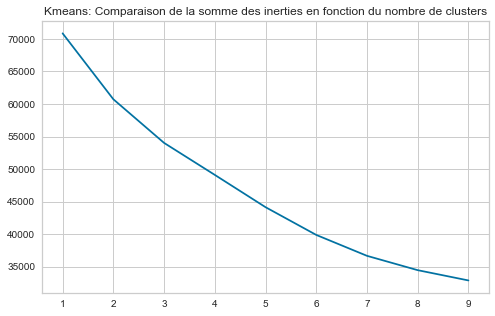

In [24]:
plt.figure(figsize=(8,5))
plt.title('Kmeans: Comparaison de la somme des inerties en fonction du nombre de clusters')
sns.lineplot(list(inertia_e.keys()),
             list(inertia_e.values())
            )

In [25]:
inertia_e = {}
dict_kmeans_e = {}

nb_boucles=3
max_clusters = 10

for k in range(1,nb_boucles+1):
    print('Boucle ',k)
    for i in range(1,max_clusters+1):
        kmeans_echantillon = KMeans(n_clusters=i,
                                    init='k-means++',
                                    ).fit(X)
        inertia_e[(k,i)] = kmeans_echantillon.inertia_
        dict_kmeans_e[k,i] = kmeans_echantillon

Boucle  1
Boucle  2
Boucle  3


C:\Users\sahel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sahel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sahel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


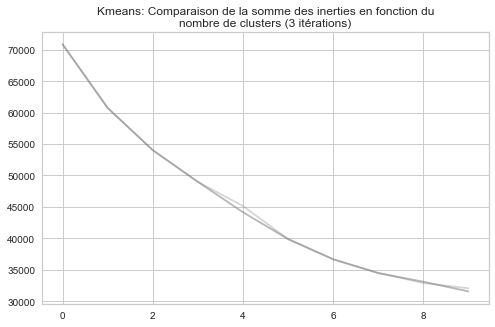

In [26]:
chaine = 'Kmeans: Comparaison de la somme des inerties en fonction du\nnombre de clusters (' + str(nb_boucles) + ' itérations)'
plt.figure(figsize=(8,5))
plt.title(chaine)
for i in range(0,nb_boucles):
    index_plot = [cluster+i*(max_clusters) for cluster in list(range(0,max_clusters))][0:max_clusters]
    sous_liste = [list(inertia_e.values())[index] for index in index_plot]
    sns.lineplot(list(range(0,max_clusters)),
                 sous_liste, alpha=1/nb_boucles, color='grey')

#### Coefficient de silhouette (Échantillon)

In [27]:
silhouettes_kmeans_echantillon = {}
for i in range(2,max_clusters):
    silhouettes_kmeans_echantillon[i] = silhouette_score(X = X,
                                             labels= list(dict_kmeans_e[(1,i)].labels_))

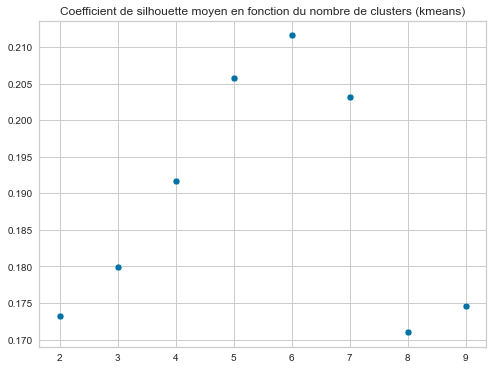

In [28]:
plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(silhouettes_kmeans_echantillon.keys()),
               y = list(silhouettes_kmeans_echantillon.values()))
plt.show()

In [29]:
for key, value in silhouettes_kmeans_echantillon.items():
    if value == max(silhouettes_kmeans_echantillon.values()):
        print('le coefficient de silhouette est maximal pour {} clusters (score = {})'.format(key, value))
        nb_clusters_e = key

le coefficient de silhouette est maximal pour 6 clusters (score = 0.21156921307322646)


In [30]:
nb_clusters_e

6

#### Indice de Davies Bouldin (Échantillon)

In [31]:
davies_bouldin_kmeans_echantillon = {}
for i in range(2,max_clusters):
    davies_bouldin_kmeans_echantillon[i] = davies_bouldin_score(X = X,
                                             labels= list(dict_kmeans_e[(1,i)].labels_))

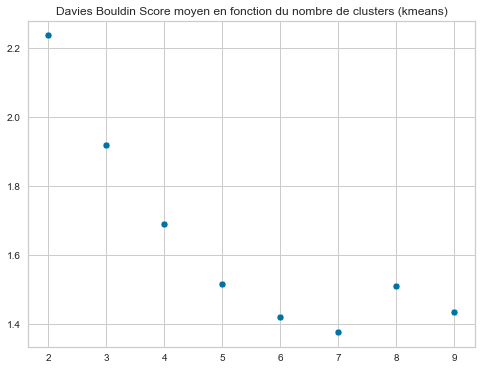

In [32]:
plt.figure(figsize=(8,6)),
plt.title('Davies Bouldin Score moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(davies_bouldin_kmeans_echantillon.keys()),
               y = list(davies_bouldin_kmeans_echantillon.values()))
plt.show()

In [33]:
for key, value in davies_bouldin_kmeans_echantillon.items():
    if value == min(davies_bouldin_kmeans_echantillon.values()):
        print('le score de Davies Bouldin est minimal pour {} clusters (score = {})'.format(key, value))

le score de Davies Bouldin est minimal pour 7 clusters (score = 1.375452998035392)


#### Score Elbow

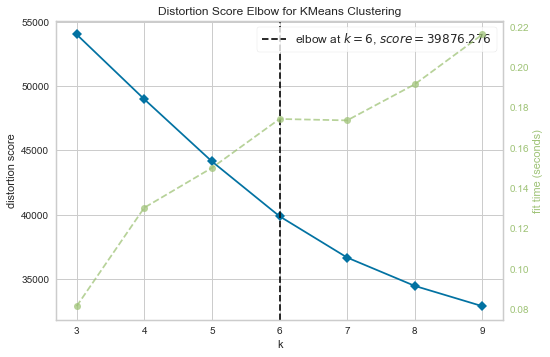

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,10))

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

##### On décide de faire notre KMeans avec K=6

#### <span style='color:green '>KMeans </span>

In [35]:
kmeans_echantillon = KMeans(n_clusters= 6,
                            init='k-means++',
                            random_state= 0,
                            ).fit(X)

In [36]:
kmeans_echantillon.labels_

array([0, 3, 3, ..., 0, 4, 0])

In [37]:
# Predicting the cluster labels
labels = kmeans_echantillon.predict(X)

In [38]:
X['labels'] = kmeans_echantillon.labels_

In [39]:
X.head()

,order_delivered,mois_achat,review_score,paid_credit_card,Recency,construction,electronics,fashion,food_drink,furniture,health_beauty,home,office,sports_leisure,supplies,total_items,total_price,harvesine_distance,labels
customer_unique_id,,,,,,,,,,,,,,,,,,,
17d7f3a57687a59fdf418ccc22adc301,1,-0.626406,-0.071695,1,-0.697955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.428349,-0.311175,0.669721,0
146495fd4550cf115b5babe8307f289d,1,1.853213,0.677186,1,0.174177,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.428349,0.676682,-0.600525,3
6e0cb36c00403df8d4bfe324ba3e30a8,1,1.543261,0.677186,1,0.298768,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.428349,0.975264,0.669721,3
c1fd58a403b64c390deeac65e1b6347b,1,1.233308,0.677186,1,0.547948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.411296,1.761329,-0.600525,5
f801278dc42ce9d4773cb91ad0e21ab8,1,-1.556264,0.677186,1,2.272541,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.411296,-0.201079,1.134974,3


### T-SNE

In [40]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(X.copy())

C:\Users\sahel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Représentation T-SNE de la séparation du jeu de données via KMeans (6 clusters)'}>

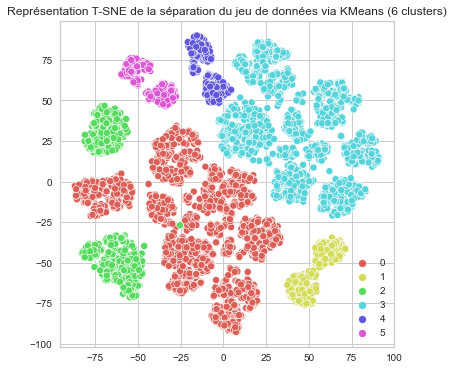

In [41]:
plt.figure(figsize=(6,6))
plt.title('Représentation T-SNE de la séparation du jeu de données via KMeans (6 clusters)')
sns.scatterplot(T[:,0], 
                T[:,1],
                hue=dict_kmeans_e[(1,6)].labels_,
                legend='full',
                palette=sns.color_palette("hls", nb_clusters_e))

##### Nos données ont la forme d’une sphère. Essayons quand même avec le model DBSCAN. 

#### <span style='color:green '>DBSCAN </span>

In [42]:
dbs = DBSCAN(eps = 1, 
             min_samples=5,
               n_jobs=-1).fit(X.copy())

C:\Users\sahel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Représentation de la séparation des données du DBSCAN via T-SNE'}>

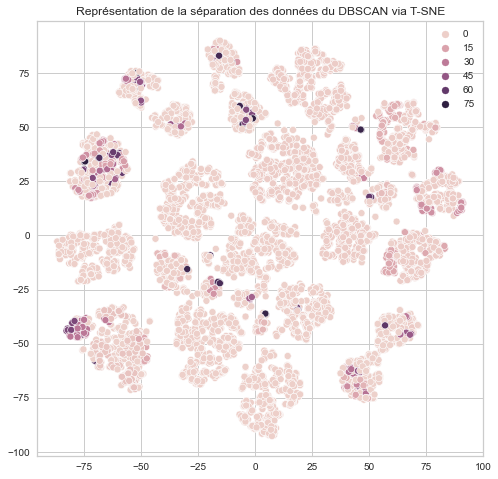

In [43]:
plt.figure(figsize=(8,8))
plt.title('Représentation de la séparation des données du DBSCAN via T-SNE')
sns.scatterplot(T[:,0], T[:,1], dbs.labels_)

##### Le Kmeans semble mieux séparer nos données que le DBSCAN, essayons d'appliquer cet algorithme à l'ensemble du jeu de données.

### <span style='color:blue '> Segmentation sur l'ensemble du jeu de données en utilisant toutes les variables  </span>

##### Nous allons d'abord faire un APC pour voir si on peut réduire notre base de données 

### PCA sur l'ensemble du jeu de données

In [44]:
from sklearn.decomposition import PCA

def display_scree_plot(pca):
#Fonction affichage du ratio de variance cumulé 
    scree = pca.explained_variance_ratio_*100
    fig=plt.figure(figsize=[16,5])
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    plt.bar(np.arange(len(scree))+1, scree,color="#6fd67b",edgecolor='black')
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='+')
    plt.xlabel("Rang de la composante principale ")
    plt.ylabel("Pourcentage d'inertie ")
    plt.title("Ratio de variance cumulée ")
    plt.grid()
    plt.show(block=False)

In [45]:
pca = PCA(n_components=min(df.shape[0],df.shape[1]))
d=pca.fit_transform(df)

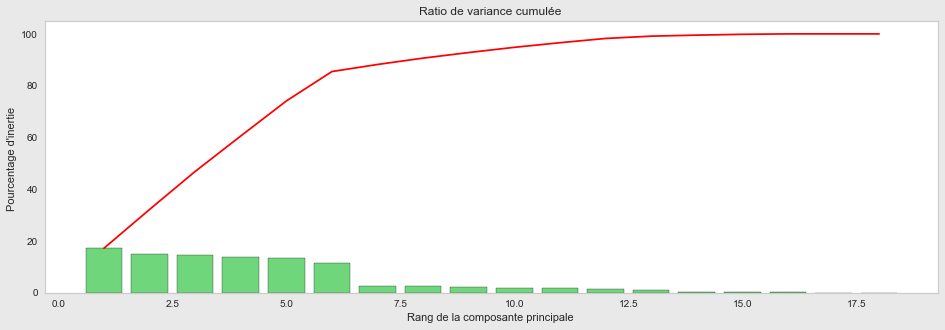

In [46]:
display_scree_plot(pca)

In [47]:
scree = pca.explained_variance_ratio_
nbr_pca=0
N=110
for i in range(N):
    a = scree.cumsum()[i]
    if a >= 0.80:
        print("{} composantes principales expliquent au moins 80 % de la variance totale ".format(i))
        print("Valeur exacte de la variance expliquée : {}%".format(round(a*100,2)))
        nbr_pca=i
        break
pca = PCA(n_components=nbr_pca)
d=pca.fit_transform(df)

5 composantes principales expliquent au moins 80 % de la variance totale 
Valeur exacte de la variance expliquée : 85.46%


In [48]:
df_pca=pd.DataFrame(d)
col=["pca "+ str(n+1) for n in df_pca.columns]
df_pca.columns=col
df_pca.head()

,pca 1,pca 2,pca 3,pca 4,pca 5
0,0.486760,0.487007,-1.303207,-0.135103,-0.370144
1,0.228250,0.567856,0.047850,-0.879533,2.129582
2,1.043194,0.327160,1.354991,-0.983103,0.094013
3,-0.043980,-1.227058,-0.090963,0.877803,-0.966835
4,0.863870,0.573666,-0.117844,-2.037811,1.791463


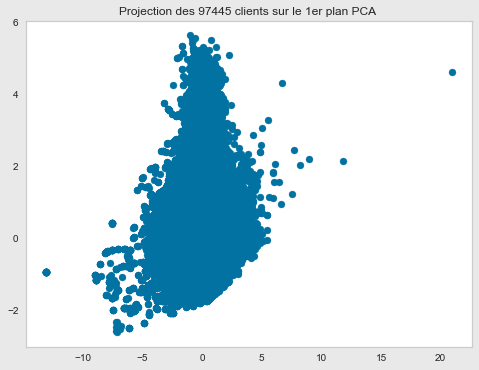

In [49]:
fig=plt.figure(figsize=[8,6])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("Projection des {} clients sur le 1er plan PCA ".format(df_pca.shape[0]))
plt.scatter(data=df_pca,x="pca 1",y="pca 2")
plt.grid()

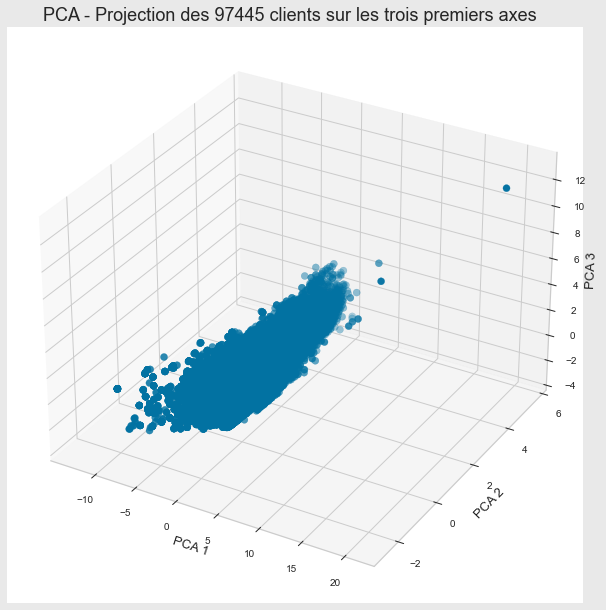

In [50]:
from mpl_toolkits.mplot3d import Axes3D
import sys

fig=plt.figure(figsize=[8,8])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
ax = Axes3D(fig)
plt.title("PCA - Projection des {} clients sur les trois premiers axes  ".format(df_pca.shape[0]),fontsize=18)

ax.set_xlabel ('PCA 1 ',fontsize=13)
ax.set_ylabel ('PCA 2 ',fontsize=13)
ax.set_zlabel ('PCA 3 ',fontsize=13)
ax.scatter(df_pca['pca 1'], df_pca['pca 2'],df_pca['pca 3'], s=50)

#### T-SNE sur l’ensemble de données 

In [51]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(df_pca.copy())

C:\Users\sahel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Représentation du jeu de données via T-SNE'}>

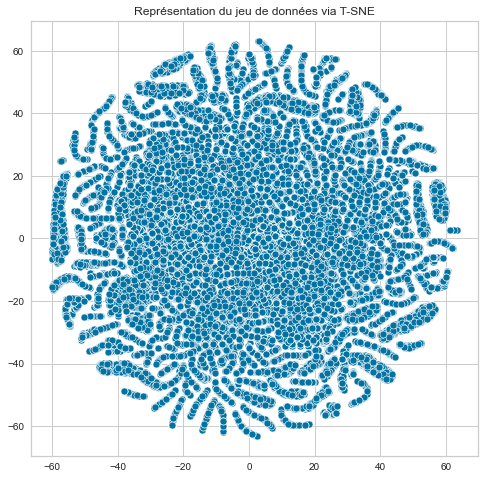

In [52]:
plt.figure(figsize=(8,8))
plt.title('Représentation du jeu de données via T-SNE')
sns.scatterplot(T[:,0], T[:,1])

### Kmeans sur l'ensemble du données

#### Score Elbow

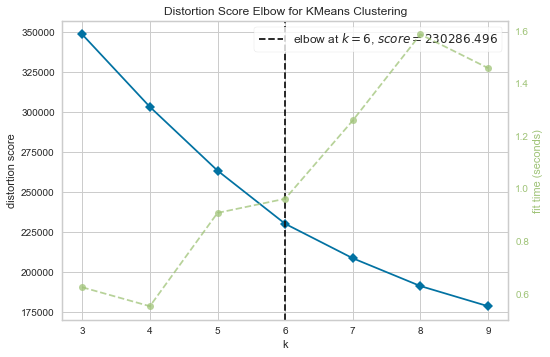

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [248]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,10))

visualizer.fit(df_pca)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Grâce à la méthode du coude, une segementation en  K=6 clusters serait la meilleure option.

In [54]:
inertia_T = {}
dict_kmeans_T = {}
dict_silhouette_T = {}
for k in range(4,8):
    kmeans_Total = KMeans(n_clusters=k,
                          init='k-means++',
                          random_state=0,
                          ).fit(df_pca)
    inertia_T[k] = kmeans_Total.inertia_
    dict_kmeans_T[k] = kmeans_Total
    dict_silhouette_T[k] = silhouette_score(X = df_pca, labels= kmeans_Total.labels_)
    print('Boucle {} - Silhouette score : {}'.format(k, dict_silhouette_T[k]))

Boucle 4 - Silhouette score : 0.27627492237593987
Boucle 5 - Silhouette score : 0.28839166931894594
Boucle 6 - Silhouette score : 0.2882007160684597
Boucle 7 - Silhouette score : 0.2549059451328387


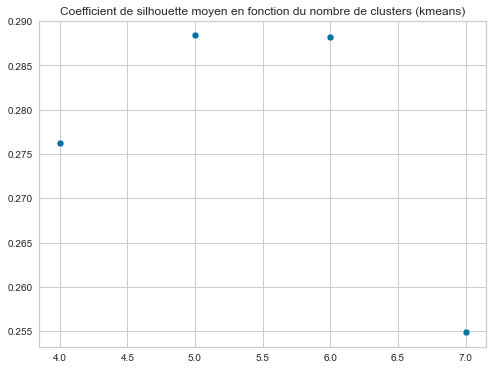

In [55]:
plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(dict_silhouette_T.keys()),
               y = list(dict_silhouette_T.values()))
plt.show()

In [56]:
for key, value in dict_silhouette_T.items():
    if value == max(dict_silhouette_T.values()):
        print('le coefficient de silhouette est maximal pour {} clusters (score = {})'.format(key, value))
        nb_clusters_T = key

le coefficient de silhouette est maximal pour 5 clusters (score = 0.28839166931894594)


In [57]:
nb_clusters_T

5

#### Le KMeans avec 5 cluster

In [249]:
# elbow method => nb clusters = 6
kmeans_Total = KMeans(n_clusters= 6,
                            init='k-means++',
                            random_state= 0,
                            ).fit(df_pca)

In [250]:
kmeans_Total.labels_

array([5, 0, 1, ..., 5, 5, 1])

In [251]:
# Predicting the cluster labels
labels = kmeans_Total.predict(df_pca)

#### T-SNE

In [252]:
T_T = tsne.fit_transform(df_pca.copy())

C:\Users\sahel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:title={'center':'Représentation T-SNE de la séparation du jeu de données via KMeans (5 clusters)'}>

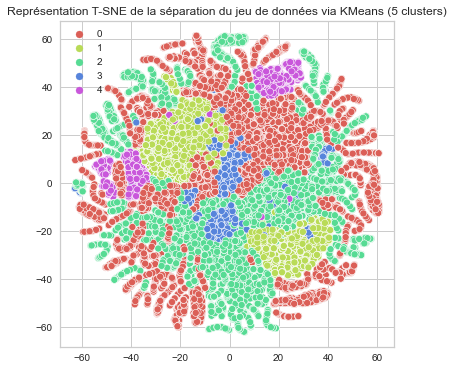

In [253]:
plt.figure(figsize=(6,6))
plt.title('Représentation T-SNE de la séparation du jeu de données via KMeans (5 clusters)')
sns.scatterplot(T_T[:,0], 
                T_T[:,1],
                hue=dict_kmeans_T[5].labels_,
                legend='full',
                palette=sns.color_palette("hls", nb_clusters_T))

#### Projection de l'individu au premier plan de l'ACP via KMeans Cluster

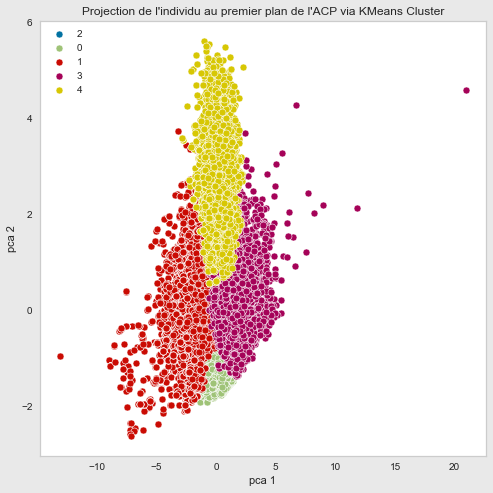

In [63]:
kmeans_Total = KMeans(n_clusters= 5,random_state= 0).fit(df_pca)
labs= kmeans_Total.labels_

test=df_pca.loc[:,["pca 1","pca 2"]]
test["cluster kmeans"]=labs
fig=plt.figure(figsize=[8,8])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("Projection de l'individu au premier plan de l'ACP via KMeans Cluster")
for clu in test["cluster kmeans"].unique():
    t=test.loc[test["cluster kmeans"]==clu]
    sns.scatterplot(x=t['pca 1'],y= t['pca 2'],label=clu)
plt.legend()
plt.grid()
plt.show()

#### Scores de stabilité à l'initialisation 

In [187]:
labels = kmeans_Total.labels_

In [188]:
def bench_k_means(model, name, data, labels):
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[1].inertia_]
    
    # Test differents metrics on pred labels
    clustering_metrics = [
        homogeneity_score,
        adjusted_rand_score,
        adjusted_mutual_info_score]
    results += [m(labels, estimator[1].labels_) for m in clustering_metrics]
    
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [189]:
print("Scores de stabilité à l'initialisation")
print(53 * '_')
print('Iteration\tFitTime\tInertia\tHomo\tARI\tAMI')
print(53 * '_')

for i in range(10):
    imodel = KMeans(n_clusters=K, n_init=1, init="k-means++")
    bench_k_means(model = imodel, name="Iter "+str(i), 
                  data=df_pca, labels=labels)

print(53 * '_')

Scores de stabilité à l'initialisation
_____________________________________________________
Iteration	FitTime	Inertia	Homo	ARI	AMI
_____________________________________________________
Iter 0   	0.098s	1099	0.512	0.544	0.515
Iter 1   	0.083s	1106	0.376	0.414	0.384
Iter 2   	0.094s	1099	0.514	0.549	0.517
Iter 3   	0.091s	1099	0.512	0.544	0.515
Iter 4   	0.087s	1099	0.512	0.543	0.515
Iter 5   	0.130s	1099	0.513	0.549	0.517
Iter 6   	0.099s	1106	0.375	0.414	0.383
Iter 7   	0.118s	1106	0.375	0.413	0.383
Iter 8   	0.099s	1106	0.375	0.414	0.383
Iter 9   	0.118s	1099	0.513	0.549	0.517
_____________________________________________________


### <span style='color:blue '> Segmentation RFM  </span>

##### Maintenant nous allons refaire la segmentation avec un classement RFM. 

In [64]:
df_RFM = df[['Recency','total_items','total_price']]

In [65]:
df_RFM.shape

(97445, 3)

In [66]:
df_RFM.head()

,Recency,total_items,total_price
customer_unique_id,,,
871766c5855e863f6eccc05f988b23cb,0.738113,-0.428349,-0.426159
eb28e67c4c0b83846050ddfb8a35d051,1.656147,0.411296,1.524605
3818d81c6709e39d06b2738a8d3a2474,-0.068446,-0.428349,1.077980
af861d436cfc08b2c2ddefd0ba074622,-1.419268,-0.428349,-0.908652
64b576fb70d441e8f1b2d7d446e483c5,2.187295,-0.428349,1.090143


#### Score Elbow

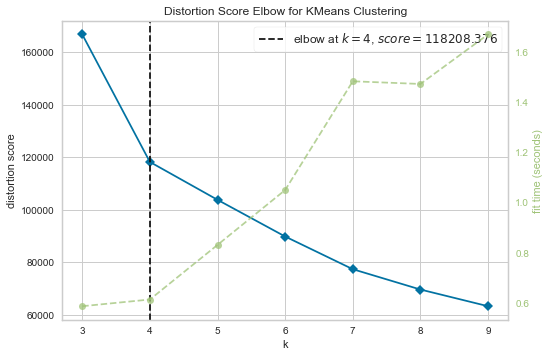

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [67]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,10))

visualizer.fit(df_RFM)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Grâce à la méthode du coude, une segementation en  
K
=
4
clusters serait la meilleure option.

### Best of K Silhouette

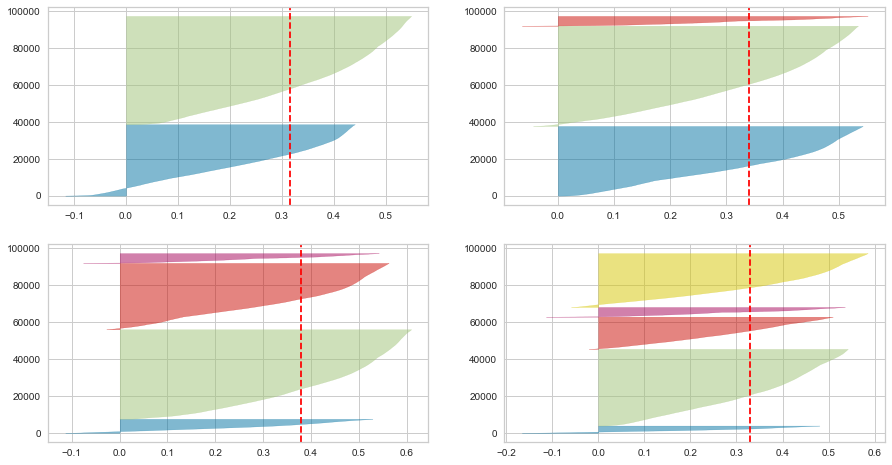

In [68]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_RFM)

In [69]:
# elbow method => nb clusters = 4
kmeans_RFM = KMeans(n_clusters= 4,
                     init='k-means++',
                    random_state= 0).fit(df_RFM)

In [70]:
kmeans_RFM.labels_

array([0, 0, 2, ..., 0, 0, 2])

In [71]:
# Predicting the cluster labels
labels = kmeans_RFM.predict(df_RFM)

In [72]:
data_RFM['labels'] = kmeans_RFM.labels_

In [73]:
df_RFM['clusterRFM'] = kmeans_RFM.labels_

<ipython-input-73-f3237bf6e6a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RFM['clusterRFM'] = kmeans_RFM.labels_


In [74]:
silhouette_score(X = df_RFM, labels= kmeans_RFM.labels_)

0.5547021889049348

In [75]:
inertia_RFM = {}
dict_kmeans_RFM = {}
dict_silhouette_RFM = {}
for k in range(4,8):
    kmeans_RFM = KMeans(n_clusters=k,
                   init='k-means++',
                   random_state=0,
                   ).fit(df_RFM)
    inertia_RFM[k] = kmeans_RFM.inertia_
    dict_kmeans_RFM[k] = kmeans_RFM
    dict_silhouette_RFM[k] = silhouette_score(X = df_RFM, labels= kmeans_RFM.labels_)
    print('Boucle {} - Silhouette score : {}'.format(k, dict_silhouette_RFM[k]))

Boucle 4 - Silhouette score : 0.5547021889049348
Boucle 5 - Silhouette score : 0.5552866482154017
Boucle 6 - Silhouette score : 0.4479336640933928
Boucle 7 - Silhouette score : 0.32180043507198297


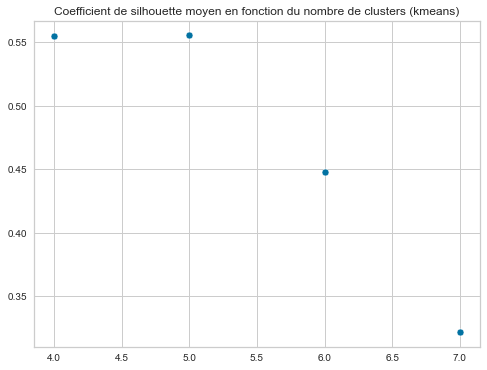

In [76]:
plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(dict_silhouette_RFM.keys()),
               y = list(dict_silhouette_RFM.values()))
plt.show()

In [77]:
for key, value in dict_silhouette_RFM.items():
    if value == max(dict_silhouette_RFM.values()):
        print('le coefficient de silhouette est maximal pour {} clusters (score = {})'.format(key, value))
        nb_clusters_RFM = key

le coefficient de silhouette est maximal pour 5 clusters (score = 0.5552866482154017)


In [78]:
nb_clusters_RFM

5

#### T-SNE

In [79]:
T_RFM = tsne.fit_transform(df_RFM.copy())

C:\Users\sahel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:title={'center':'Représentation T-SNE de la séparation du jeu de données via Kmeans (une segmentation RFM)'}>

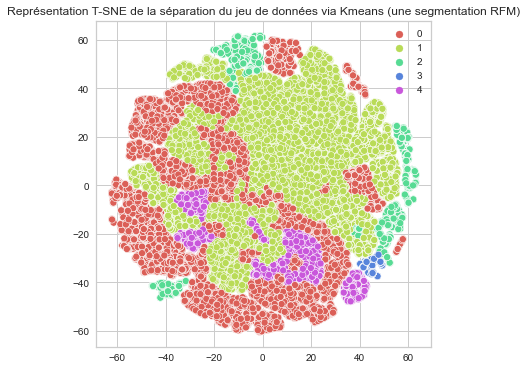

In [259]:
plt.figure(figsize=(6,6))
plt.title('Représentation T-SNE de la séparation du jeu de données via Kmeans (une segmentation RFM)')
sns.scatterplot(T_RFM[:,0], 
                T_RFM[:,1],
                hue= dict_kmeans_RFM[5].labels_,
                legend='full',
                palette=sns.color_palette("hls", nb_clusters_RFM))

#### Stabilité du kmeans avec Adjusted_rand

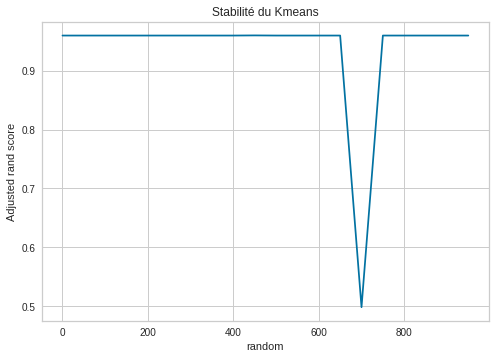

In [ ]:
# stabilité du kmeans avec Adjusted_rand
def kmeans_stab_random(df_RFM, clusters, n_clusters, range_start=0,
                       range_end=1000, step=50, name=''):
    ARI = []
    for rand in range(range_start, range_end, step):
        kmStab = cluster.KMeans(n_clusters=n_clusters,
                                random_state=rand).fit(df_RFM)
        clustersPred = kmStab.labels_
        ARI.append(metrics.adjusted_rand_score(clusters, clustersPred))

    plt.plot(range(range_start, range_end, step), ARI, 'bx-')
    plt.xlabel('random')
    plt.ylabel('Adjusted rand score')
    plt.title('Stabilité du Kmeans')
    plt.savefig('fig/kmean_stab_ARI_' + name + '_' +
                name_export + '.png', bbox_inches='tight')
    plt.show()

clusters = kmeans.labels_
kmeans_stab_random(df_RFM, clusters, 4, 0, 1000, 50, 'rfm')

La stabilité du Modèle change après 650 itérations. 

In [87]:
data_RFM.groupby(['labels'])[['Recency', 'total_items', 'total_price']].agg(['count','max','min','mean'])

Recency                       total_items                       \
         count  max  min        mean       count   max  min      mean   
labels                                                                  
0        35770  695  255  388.200951       35770   4.0  1.0  1.314789   
1         5296  692    0  245.615370        5296  21.0  4.0  5.393882   
2        48715  259    0  126.817510       48715   3.0  1.0  1.288063   
3         7664  694    0  231.276618        7664   6.0  1.0  1.149922   

       total_price                               
             count      max     min        mean  
labels                                           
0            35770   313.72    9.27   93.102088  
1             5296   603.52    9.09   71.824705  
2            48715   255.48    7.28   94.017262  
3             7664  4034.44  212.03  357.288439

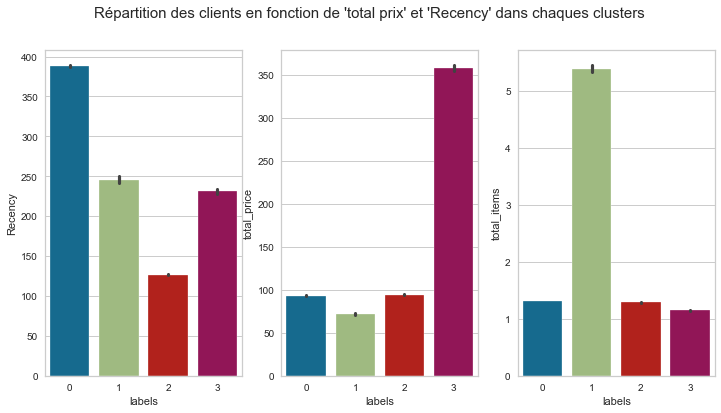

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(12,6))
sns.barplot(x='labels',y='Recency',data=data_RFM, ax=axes[0])
sns.barplot(x='labels',y='total_price',data=data_RFM, ax=axes[1])
sns.barplot(x='labels',y='total_items',data=data_RFM, ax=axes[2])
plt.suptitle("Répartition des clients en fonction de 'total prix' et 'Recency' dans chaques clusters",
             fontsize=15)
plt.show()

<AxesSubplot:title={'center':"Distribution du nombre d'individus par cluster, en pourcentage"}>

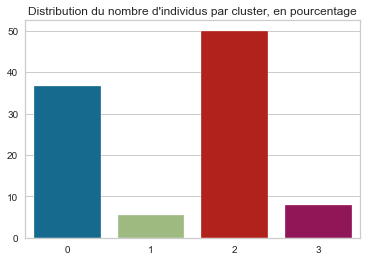

In [89]:
plt.figure(figsize=(6,4))
plt.title('Distribution du nombre d\'individus par cluster, en pourcentage')
sns.barplot(x = data_RFM['labels'].value_counts().index, 
           y=data_RFM['labels'].value_counts().values/len(data_RFM)*100)

In [ ]:
# 0 => Les nouveaux clients
# 1 => Les clients ayant acheté le plus de produits
# 2 => Les clients à reconquerir
# 3 => Les clients les plus dépensiers

In [235]:
types_clients = ['Les nouveaux clients','Les clients ayant acheté le plus de produits','Les clients à reconquerir','Les clients les plus dépensiers']

In [236]:
def setCustomersType(x, types_clients= types_clients):
    return types_clients[x]

In [240]:
df_RFM.head()

,Recency,total_items,total_price,clusterRFM
customer_unique_id,,,,
871766c5855e863f6eccc05f988b23cb,0.738113,-0.428349,-0.426159,0
eb28e67c4c0b83846050ddfb8a35d051,1.656147,0.411296,1.524605,0
3818d81c6709e39d06b2738a8d3a2474,-0.068446,-0.428349,1.077980,2
af861d436cfc08b2c2ddefd0ba074622,-1.419268,-0.428349,-0.908652,2
64b576fb70d441e8f1b2d7d446e483c5,2.187295,-0.428349,1.090143,0


In [241]:
df_RFM['types_clients']  = df_RFM['clusterRFM'].apply(lambda x: setCustomersType(x))

<ipython-input-241-f6c5a74857be>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [242]:
df_RFM.head()

,Recency,total_items,total_price,clusterRFM,types_clients
customer_unique_id,,,,,
871766c5855e863f6eccc05f988b23cb,0.738113,-0.428349,-0.426159,0,Les nouveaux clients
eb28e67c4c0b83846050ddfb8a35d051,1.656147,0.411296,1.524605,0,Les nouveaux clients
3818d81c6709e39d06b2738a8d3a2474,-0.068446,-0.428349,1.077980,2,Les clients à reconquerir
af861d436cfc08b2c2ddefd0ba074622,-1.419268,-0.428349,-0.908652,2,Les clients à reconquerir
64b576fb70d441e8f1b2d7d446e483c5,2.187295,-0.428349,1.090143,0,Les nouveaux clients


In [243]:
# visualisation des clusters (radar)
def radar_plot(rfm_table, label_score, colors, sub_plot=[3, 3], figsize=(36, 18)):

    """
    Pour chaque cluster/segments, trace un radar chart représentant
    la moyenne des individus pour les variables Recency, Monetary
    et Frequency, ainsi que le nombre d'individus dans le cluster/segment
    en question.
    rfmTable(pd.DataFrame): Table de résultats, doit contenir
    les 3 variables Recency, Frequency et Monetary
    ainsi que la colonne avec les segments de chaque individu
    label_score: nom de la segmentation
    colors(list): code couleur
    """

    # Aggrégation par moyenne des valeurs par segment
    df_plot = rfm_table.groupby([label_score]).agg("mean")

    # Transformation MinMax -> [0, 1]
    df_plot_std = pd.DataFrame(MinMaxScaler().fit_transform(df_plot),
                           columns=list(df_plot.columns),
                           index=df_plot.index)

    # Noms des variables
    categories = list(df_plot.columns)
    # Nombre de variables
    N = len(categories)
    
    # Quel sera l'angle de chaque axe ?
    # On divise un tour complet par le nombre de variables
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(1, figsize=figsize)

    # Trace un radar chart pour chaque segment
    for i, segment in enumerate(rfm_table[label_score].unique()):

        ax = fig.add_subplot(sub_plot[0], sub_plot[1], i + 1, polar=True)

        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)

        # Draw one axe per variable + add labels labels yet
        plt.yticks(color="grey", size=2)
        values = list(df_plot_std.loc[segment].values)
        values += values[:1]
        ax.plot(angles, values, colors[segment],
                'o-', linewidth=2, linestyle='solid')
        ax.fill(angles, values, colors[segment], alpha=0.25)
        ax.set_xticks(angles)
        ax.set_xticklabels(categories, size=15)
        plt.yticks([-1, -0.5, 0, 0.5, 1],
                   ["-1", "-0.5", "0", "0.5", "1"],
                   color="black",
                   size=12)
        ax.set_title(segment, size=15, color=colors[segment])
        ax.grid(True)
        plt.ylim(-1, 1)

    plt.show()

In [244]:
palette_1 = sns.color_palette("husl", len(types_clients))
colors_1 = {label: color for label, color in zip(types_clients, palette_1.as_hex())}

In [245]:
colors_1

{'Les nouveaux clients': '#f77189',
 'Les clients ayant acheté le plus de produits': '#97a431',
 'Les clients à reconquerir': '#36ada4',
 'Les clients les plus dépensiers': '#a48cf4'}

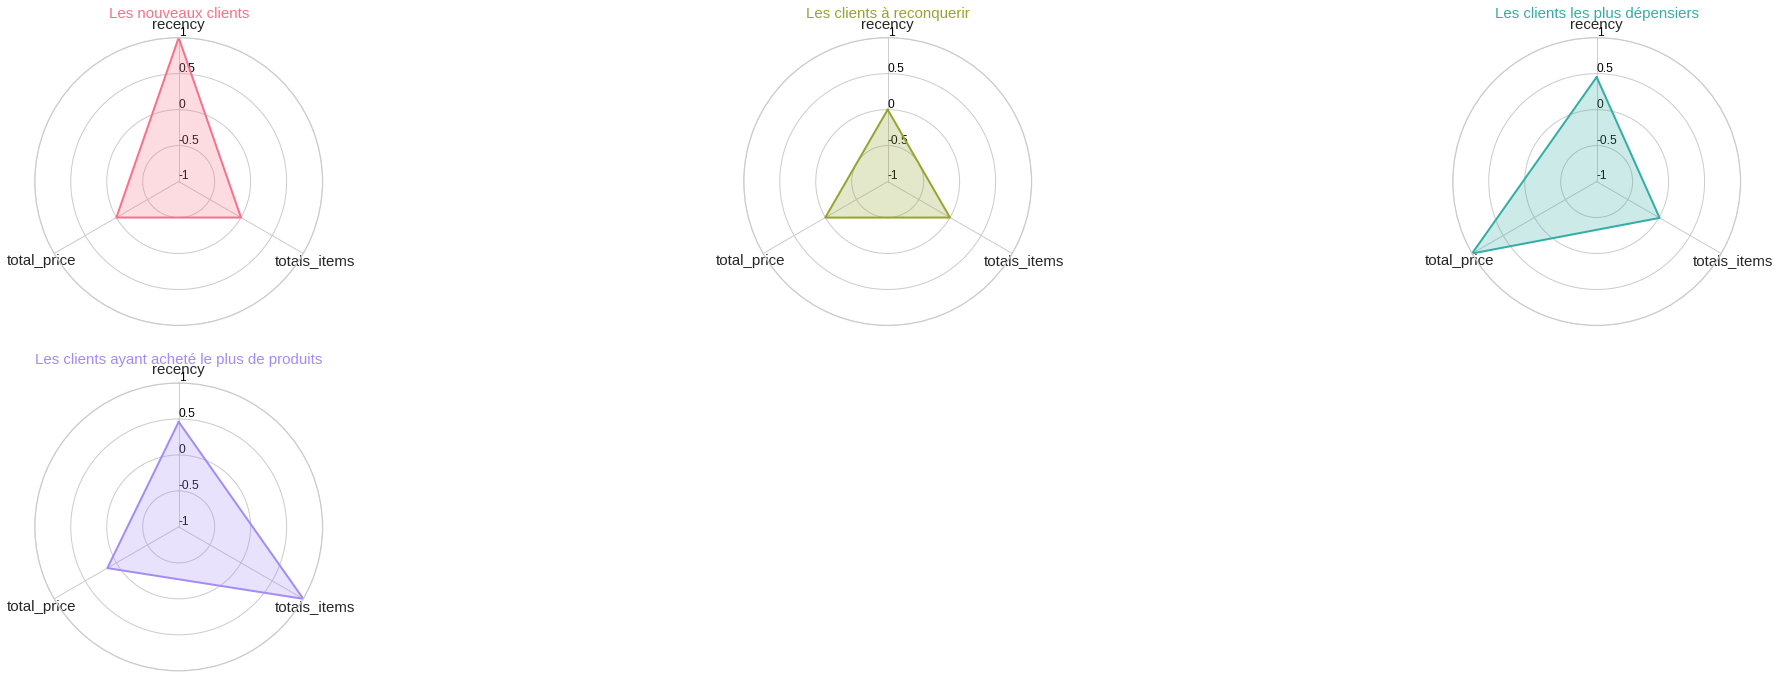

In [ ]:
# Radar plot pour la segmentation
radar_plot(data_rfm_client.drop(columns=['clusters']) ,'types_clients',  colors_1, sub_plot=[3, 3])

### <span style='color:blue '> Segmentation avec 5 features  </span>

Nous allons refaire la segmentation en ajoutant 2 variables aux features RFM

In [98]:
df_5 = df[['review_score','Recency','total_items', 'total_price','harvesine_distance']]

In [99]:
df_5.head()

,review_score,Recency,total_items,total_price,harvesine_distance
customer_unique_id,,,,,
871766c5855e863f6eccc05f988b23cb,0.677186,0.738113,-0.428349,-0.426159,0.349803
eb28e67c4c0b83846050ddfb8a35d051,-0.071695,1.656147,0.411296,1.524605,-0.600525
3818d81c6709e39d06b2738a8d3a2474,0.677186,-0.068446,-0.428349,1.077980,0.669721
af861d436cfc08b2c2ddefd0ba074622,-0.071695,-1.419268,-0.428349,-0.908652,-0.600525
64b576fb70d441e8f1b2d7d446e483c5,0.677186,2.187295,-0.428349,1.090143,-0.600525


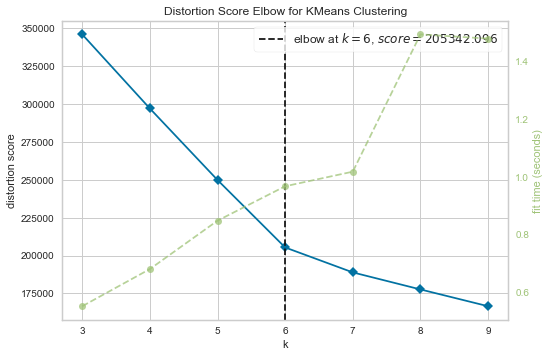

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [100]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,10))

visualizer.fit(df_5)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

#### Kmeans 

In [123]:
# elbow method => nb clusters = 6
kmeans_5 = KMeans(n_clusters= 6,
                  init='k-means++',
                  random_state= 0).fit(df_5)

In [124]:
kmeans_5.labels_

array([3, 3, 2, ..., 3, 3, 2])

In [125]:
# Predicting the cluster labels
labels = kmeans_5.predict(df_5)

In [126]:
data_5['cluster'] = kmeans_5.labels_

<ipython-input-126-1360f1215371>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_5['cluster'] = kmeans_5.labels_


In [127]:
df_5['labels'] = kmeans_5.labels_

<ipython-input-127-25140a79aea9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['labels'] = kmeans_5.labels_


In [128]:
data_5.head(2)

,review_score,Recency,total_items,total_price,harvesine_distance,cluster
customer_unique_id,,,,,,
871766c5855e863f6eccc05f988b23cb,5,350,1.0,72.19,430.600094,3
eb28e67c4c0b83846050ddfb8a35d051,4,490,2.0,259.83,209.024370,3


In [130]:
silhouette_score(X = df_5, labels= kmeans_5.labels_)

0.36616378292536833

In [131]:
inertia_5 = {}
dict_kmeans_5 = {}
dict_silhouette_5 = {}
for k in range(4,8):
    kmeans_5 = KMeans(n_clusters=k,
                   init='k-means++',
                   random_state=0,
                   ).fit(df_5)
    inertia_5[k] = kmeans_5.inertia_
    dict_kmeans_5[k] = kmeans_5
    dict_silhouette_5[k] = silhouette_score(X = df_5, labels= kmeans_5.labels_)
    print('Boucle {} - Silhouette score : {}'.format(k, dict_silhouette_5[k]))

Boucle 4 - Silhouette score : 0.2938359237185055
Boucle 5 - Silhouette score : 0.3255473654579094
Boucle 6 - Silhouette score : 0.36616378292536833
Boucle 7 - Silhouette score : 0.30987708781611983


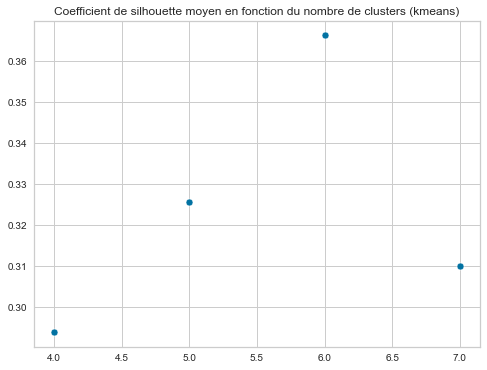

In [132]:
plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(dict_silhouette_5.keys()),
               y = list(dict_silhouette_5.values()))
plt.show()

In [133]:
for key, value in dict_silhouette_5.items():
    if value == max(dict_silhouette_5.values()):
        print('le coefficient de silhouette est maximal pour {} clusters (score = {})'.format(key, value))
        nb_clusters_5 = key

le coefficient de silhouette est maximal pour 6 clusters (score = 0.36616378292536833)


In [134]:
nb_clusters_5

6

Le coefficient de silhouette est le plus élevé pour ce modèle. Nous allons donc le meilleur model avec les 5 variables choisies

#### T-SNE

In [135]:
T_5 = tsne.fit_transform(df_5.copy())

C:\Users\sahel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Représentation T-SNE de la séparation du jeu de données via Kmeans (6 clusters) avec 5 variables'}>

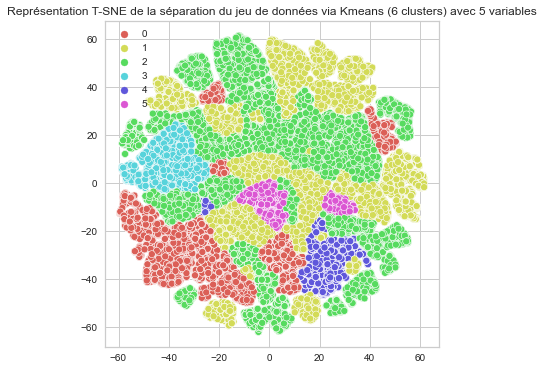

In [136]:
plt.figure(figsize=(6,6))
plt.title('Représentation T-SNE de la séparation du jeu de données via Kmeans (6 clusters) avec 5 variables')
sns.scatterplot(T_5[:,0], 
                T_5[:,1],
                hue= dict_kmeans_5[6].labels_,
                legend='full',
                palette=sns.color_palette("hls", nb_clusters_5))

#### Scores de stabilité à l'initialisation avec 5 variables

In [162]:
labels = kmeans_5.labels_

In [163]:
print("Scores de stabilité à l'initialisation")
print(53 * '_')
print('Iteration\tFitTime\tInertia\tHomo\tARI\tAMI')
print(53 * '_')

for i in range(10):
    imodel = KMeans(n_clusters=K, n_init=1, init="k-means++")
    bench_k_means(model = imodel, name="Iter "+str(i), 
                  data=df_5, labels=labels)

print(53 * '_')

Scores de stabilité à l'initialisation
_____________________________________________________
Iteration	FitTime	Inertia	Homo	ARI	AMI
_____________________________________________________
Iter 0   	0.072s	6844	0.712	0.803	0.813
Iter 1   	0.064s	6844	0.712	0.803	0.813
Iter 2   	0.099s	7643	0.583	0.696	0.664
Iter 3   	0.096s	7643	0.583	0.696	0.664
Iter 4   	0.088s	7629	0.561	0.658	0.626
Iter 5   	0.080s	6844	0.712	0.803	0.813
Iter 6   	0.082s	6844	0.712	0.803	0.813
Iter 7   	0.073s	7560	0.606	0.624	0.659
Iter 8   	0.066s	6844	0.712	0.803	0.813
Iter 9   	0.086s	6844	0.712	0.803	0.813
_____________________________________________________


In [138]:
data_5.groupby(['cluster'])[['Recency', 'total_items', 'total_price','harvesine_distance','review_score']].agg(['count','max','min','mean'])

Recency                       total_items                       \
          count  max  min        mean       count   max  min      mean   
cluster                                                                  
0          6103  693    1  234.272653        6103   6.0  1.0  1.142389   
1          4583  692    0  240.905739        4583  21.0  4.0  5.607462   
2         38479  264    0  121.375893       38479   3.0  1.0  1.248317   
3         28693  695  245  394.033980       28693   4.0  1.0  1.296727   
4         15137  694    0  232.364537       15137   4.0  1.0  1.570192   
5          4450  694    6  249.340899        4450   5.0  1.0  1.230787   

        total_price                              harvesine_distance  \
              count      max     min        mean              count   
cluster                                                               
0              6103  4034.44  225.71  383.175723               6103   
1              4583   603.52    9.09   70.151787               4583   
2             38479   266.51    9.59   95.639872              38479   
3             28693   313.72    9.27   94.674719              28693   
4             15137   358.05    7.28   99.447556              15137   
5              4450   410.37   18.50  104.935229               4450   

                                              review_score                    
                 max         min         mean        count max min      mean  
cluster                                                                       
0        1284.621559  131.447222   311.612669         6103   5   1  4.351466  
1        1061.180879  131.447222   299.558186         4583   5   1  3.877155  
2         670.612943  131.447222   299.970266        38479   5   3  4.676915  
3         670.612943  131.447222   316.596286        28693   5   2  4.633674  
4         867.986843  131.447222   332.041355        15137   3   1  1.593975  
5        1602.998930  867.986843  1142.672008         4450   5   1  3.986067

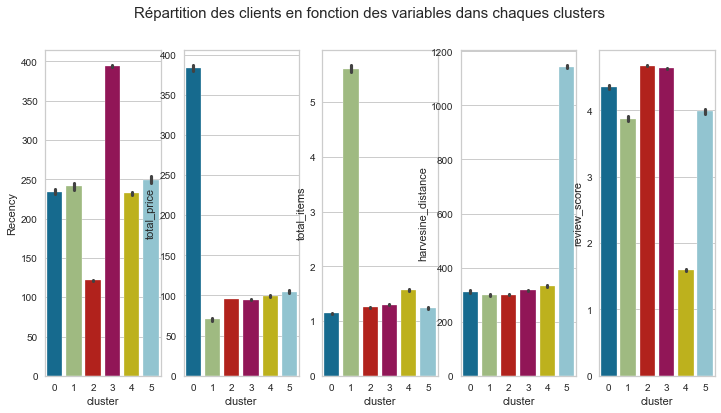

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=False, figsize=(12,6))
sns.barplot(x='cluster',y='Recency',data= data_5, ax=axes[0])
sns.barplot(x='cluster',y='total_price',data= data_5, ax=axes[1])
sns.barplot(x='cluster',y='total_items',data= data_5, ax=axes[2])
sns.barplot(x='cluster',y='harvesine_distance',data= data_5, ax=axes[3])
sns.barplot(x='cluster',y='review_score',data= data_5, ax=axes[4])

plt.suptitle("Répartition des clients en fonction des variables dans chaques clusters",
             fontsize=15)
plt.show()

<AxesSubplot:title={'center':"Distribution du nombre d'individus par cluster, en pourcentage"}>

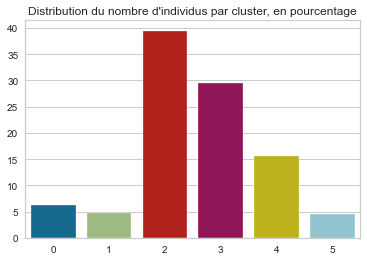

In [140]:
plt.figure(figsize=(6,4))
plt.title('Distribution du nombre d\'individus par cluster, en pourcentage')
sns.barplot(x = data_5['cluster'].value_counts().index, 
           y= data_5['cluster'].value_counts().values/len(data_5)*100)

In [ ]:
# 0 => Les clients les plus dépensiers
# 1 => Les clients ayant acheté le plus de produits
# 2 => Les clients à potanciel
# 3 => Les nouveaux clients
# 4 => Les clients insatisfaits
# 5 => Les clients les plus loin

In [141]:
types_clients_5 = ['Les clients les plus dépensiers','Les clients ayant acheté le plus de produits','Les clients à potanciel','Les nouveaux clients','Les clients insatisfaits','Les clients les plus loin']

In [149]:
def setCustomersType(x, types_clients_5 = types_clients_5):
    return types_clients_5[x]

In [150]:
data_5['types_clients_5']  = data_5['cluster'].apply(lambda x: setCustomersType(x))

<ipython-input-150-138e5f7c480f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_5['types_clients_5']  = data_5['cluster'].apply(lambda x: setCustomersType(x))


In [151]:
data_5.head()

,review_score,Recency,total_items,total_price,harvesine_distance,cluster,types_clients_5
customer_unique_id,,,,,,,
871766c5855e863f6eccc05f988b23cb,5,350,1.0,72.19,430.600094,3,Les nouveaux clients
eb28e67c4c0b83846050ddfb8a35d051,4,490,2.0,259.83,209.024370,3,Les nouveaux clients
3818d81c6709e39d06b2738a8d3a2474,5,227,1.0,216.87,505.191218,2,Les clients à potanciel
af861d436cfc08b2c2ddefd0ba074622,4,21,1.0,25.78,209.024370,2,Les clients à potanciel
64b576fb70d441e8f1b2d7d446e483c5,5,571,1.0,218.04,209.024370,3,Les nouveaux clients


In [152]:
df_5['types_clients_5']  = df_5['labels'].apply(lambda x: setCustomersType(x))

<ipython-input-152-a58d443ac0df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['types_clients_5']  = df_5['labels'].apply(lambda x: setCustomersType(x))


Nous allons faire le KMeans avec un Pipeline 

### <span style='color:blue '> Segmentation avec un Pipeline  </span>

In [161]:
df_pip = data_segmentation.copy()

In [162]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, df_pip.columns)])

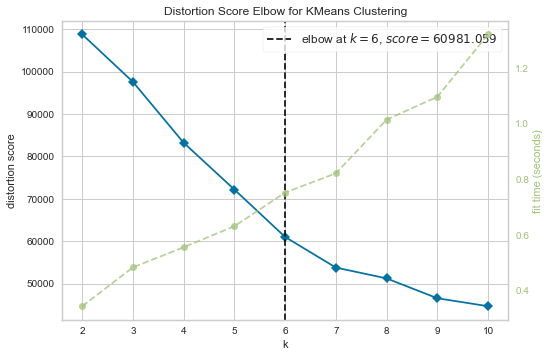

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [163]:
# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(df_pip)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

In [164]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

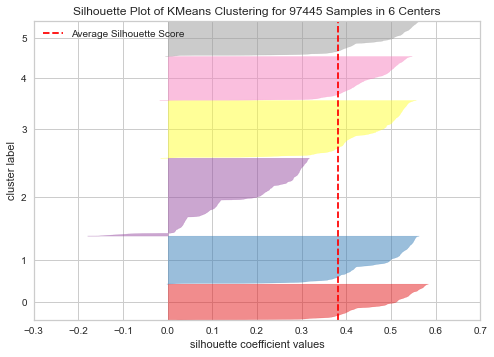

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 97445 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [165]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(df_pip)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

Ici, les clusters semblent relativement bien répartis et les séparations sont claires avec cependant quelques erreurs sur l'un des clusters.

A présent, nous allons tester d'autres types de métriques pour trouver le meilleur K :

Silouhette : rapport moyen entre la distance intra-cluster et la distance du cluster le plus proche,
Calinski Harabasz : rapport entre la dispersion des grappes dans et entre les groupes.

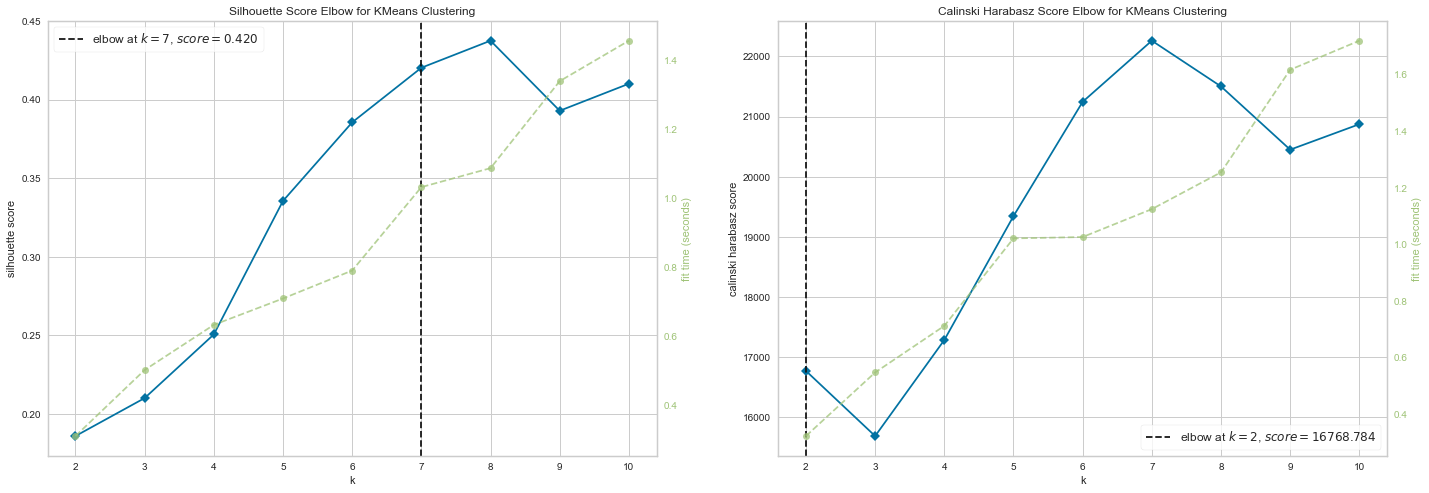

In [166]:
# Elbow method with differents metrics
metrics = ["silhouette", "calinski_harabasz"]
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
for m in metrics:
    kmeans_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                              K=(4,10),
                                              metric=m,
                                              ax=axes[i]))])
    kmeans_visualizer.fit(df_pip)
    kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
    i+=1

plt.show()

In [167]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(df_pip)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
data_segmentation["kmeans_label"] = kmeans_labels

<ipython-input-167-86a6f6426039>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [168]:
data_pip= data_segmentation.copy()

In [169]:
kmeans_clusters = data_pip.groupby("kmeans_label").mean().reset_index()
kmeans_clusters

,kmeans_label,order_delivered,mois_achat,review_score,paid_credit_card,Recency,construction,electronics,fashion,food_drink,furniture,health_beauty,home,office,sports_leisure,supplies,total_items,total_price,harvesine_distance
0,0,1.000000,6.024584,3.924706,0.755122,249.449795,0.004576,0.002235,0.000958,0.000266,0.978840,0.003352,0.005596,0.001401,0.001871,0.000905,1.831693,105.116883,332.244227
1,1,0.999872,6.296582,4.208774,0.746525,248.790715,0.002104,0.002487,0.001722,0.000701,0.003837,0.003709,0.001084,0.000638,0.983335,0.000383,1.379671,114.470576,351.226283
2,2,0.999714,6.055826,4.193781,0.764117,224.477412,0.000643,0.002109,0.001072,0.001287,0.003717,0.985311,0.001465,0.000572,0.003467,0.000357,1.386919,118.780500,351.067215
3,3,0.999957,6.086539,4.113366,0.738047,224.733677,0.241435,0.002596,0.099866,0.044611,0.003623,0.002611,0.002487,0.088630,0.003563,0.510579,1.473281,122.936573,353.536239
4,4,1.000000,5.540708,4.026000,0.695455,237.009271,0.001743,0.991217,0.000836,0.000558,0.001464,0.001150,0.001290,0.000349,0.001255,0.000139,1.411962,96.691506,368.132756
5,5,1.000000,6.064133,4.153259,0.749284,244.147010,0.003055,0.003341,0.001475,0.000434,0.010133,0.004903,0.970960,0.000550,0.004715,0.000434,1.509156,118.745381,338.216232


In [170]:
X_scaled = preprocessor.fit_transform(df_pip)
X_scaled = pd.DataFrame(X_scaled, index=df_pip.index, columns=df_pip.columns)
X_scaled["kmeans_label"] = kmeans_labels
kmeans_clusters_scaled = X_scaled.groupby("kmeans_label").mean()
kmeans_clusters_scaled

,order_delivered,mois_achat,review_score,paid_credit_card,Recency,construction,electronics,fashion,food_drink,furniture,health_beauty,home,office,sports_leisure,supplies,total_items,total_price,harvesine_distance
kmeans_label,,,,,,,,,,,,,,,,,,
0,1.000000,0.456780,0.731177,0.755122,0.358921,0.004576,0.002235,0.000958,0.000266,0.978840,0.003352,0.005596,0.001401,0.001871,0.000905,0.041585,0.024294,0.136453
1,0.999872,0.481507,0.802194,0.746525,0.357972,0.002104,0.002487,0.001722,0.000701,0.003837,0.003709,0.001084,0.000638,0.983335,0.000383,0.018984,0.026617,0.149352
2,0.999714,0.459621,0.798445,0.764117,0.322989,0.000643,0.002109,0.001072,0.001287,0.003717,0.985311,0.001465,0.000572,0.003467,0.000357,0.019346,0.027687,0.149244
3,0.999957,0.462413,0.778341,0.738047,0.323358,0.241435,0.002596,0.099866,0.044611,0.003623,0.002611,0.002487,0.088630,0.003563,0.510579,0.023664,0.028719,0.150922
4,1.000000,0.412792,0.756500,0.695455,0.341021,0.001743,0.991217,0.000836,0.000558,0.001464,0.001150,0.001290,0.000349,0.001255,0.000139,0.020598,0.022202,0.160841
5,1.000000,0.460376,0.788315,0.749284,0.351291,0.003055,0.003341,0.001475,0.000434,0.010133,0.004903,0.970960,0.000550,0.004715,0.000434,0.025458,0.027678,0.140511


Clustering sans les catégories de produits

In [173]:
categories_produits = ['construction',
       'electronics','fashion','food_drink','furniture','health_beauty',
       'home', 'office', 'sports_leisure', 'supplies']
df_s_p = df_pip.drop(categories_produits, axis=1)

df_s_p.head(3)

,order_delivered,mois_achat,review_score,paid_credit_card,Recency,total_items,total_price,harvesine_distance
customer_unique_id,,,,,,,,
871766c5855e863f6eccc05f988b23cb,1,9,5,1,350,1.0,72.19,430.600094
eb28e67c4c0b83846050ddfb8a35d051,1,4,4,1,490,2.0,259.83,209.024370
3818d81c6709e39d06b2738a8d3a2474,1,1,5,1,227,1.0,216.87,505.191218


In [174]:
def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)

    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()

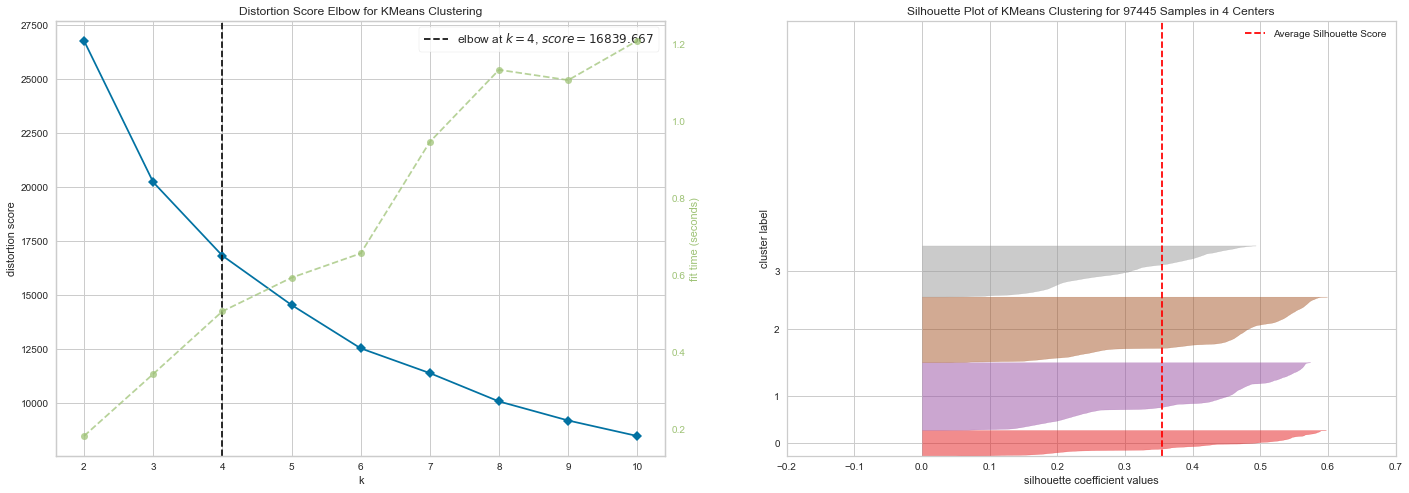

In [175]:
K = clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=df_s_p, 
                metric="distortion",
                elbow=True,
                mds=False,
                KBest=None)

Réduction dimensionnelle - PCA

In [177]:
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(df_s_p)
X_projected = pca.transform(df_s_p)

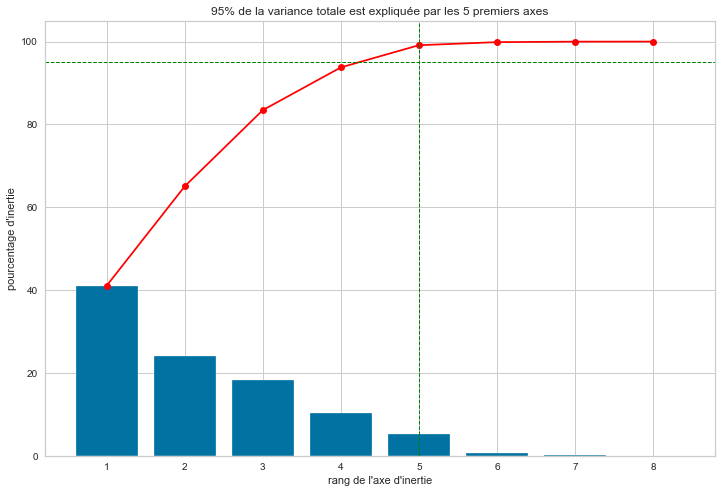

In [178]:
# Explained variance
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [179]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    fig=plt.figure(figsize=(20,n_comp*5))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)

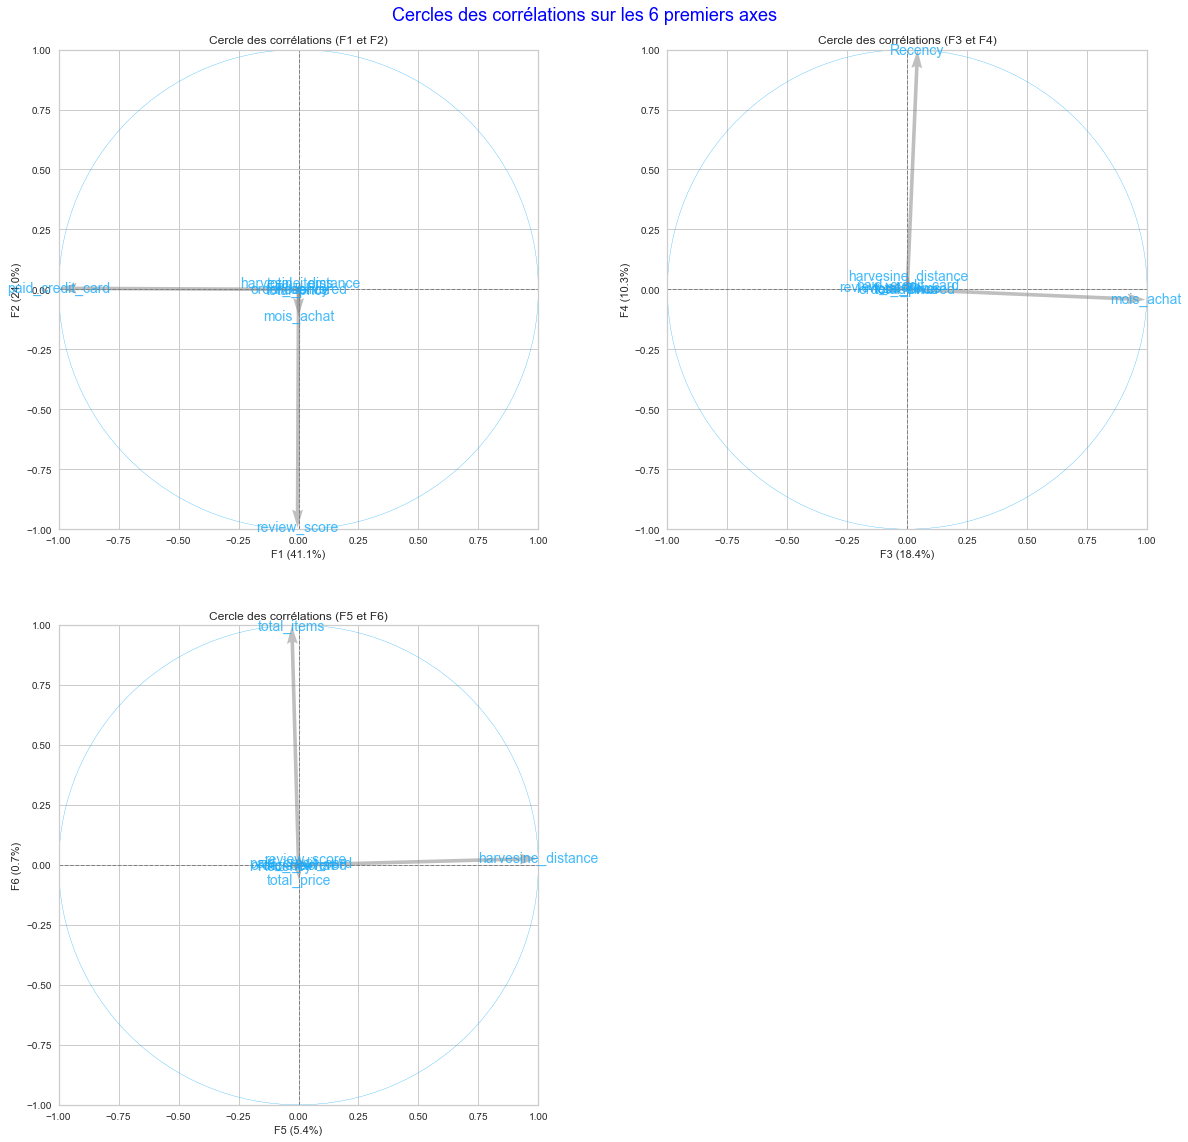

In [180]:
# Principal component space
pcs = pca.named_steps['pca'].components_

# Plot correlation circle
cerle_corr(pcs,
           6,
           pca.named_steps['pca'],
           [(0,1),(2,3),(4,5)],
           labels = np.array(df_s_p.columns))

K-Means après réduction de dimenssions

In [181]:
# KMeans Pipeline with best K for PCA results
kmeans_model_pca = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_pca.fit(X_projected[:,:4])

# Kmeans labels
pca_kmeans_labels = kmeans_model_pca.named_steps['kmeans'].labels_
X_scaled_p["kmeans_label_pca"] = pca_kmeans_labels
X_scaled_clusters_pca = X_scaled_p.groupby("kmeans_label_pca").mean()
X_scaled_clusters_pca.iloc[:,:-1]

,order_delivered,mois_achat,review_score,paid_credit_card,Recency,total_items,total_price,harvesine_distance
kmeans_label_pca,,,,,,,,
0,1.000000,0.456606,0.772778,0.0,0.350501,0.031196,0.024523,0.153279
1,0.999971,0.318499,0.896345,1.0,0.172161,0.019368,0.027163,0.139094
2,0.999615,0.435788,0.057890,1.0,0.334132,0.044685,0.025953,0.160679
3,0.999928,0.635185,0.892448,1.0,0.546575,0.020723,0.026970,0.148992


C:\Users\sahel\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



4

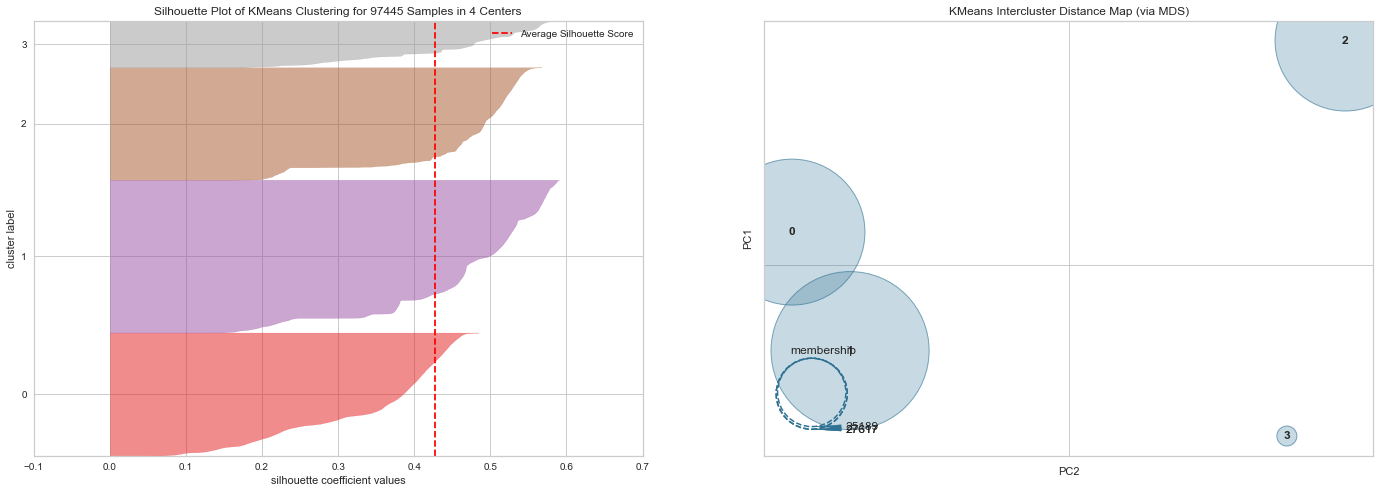

In [183]:
clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_projected[:,:4], 
                metric="distortion",
                elbow=False,
                mds=True,
                KBest=K)

#### Scores de stabilité à l'initialisation

In [184]:
labels = pca_kmeans_labels
pca_data = X_projected[:,:4]

In [185]:
def bench_k_means(model, name, data, labels):
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[1].inertia_]
    
    # Test differents metrics on pred labels
    clustering_metrics = [
        homogeneity_score,
        adjusted_rand_score,
        adjusted_mutual_info_score]
    results += [m(labels, estimator[1].labels_) for m in clustering_metrics]
    
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [186]:
print("Scores de stabilité à l'initialisation")
print(53 * '_')
print('Iteration\tFitTime\tInertia\tHomo\tARI\tAMI')
print(53 * '_')

for i in range(10):
    imodel = KMeans(n_clusters=K, n_init=1, init="k-means++")
    bench_k_means(model = imodel, name="Iter "+str(i), 
                  data=pca_data, labels=labels)

print(53 * '_')

Scores de stabilité à l'initialisation
_____________________________________________________
Iteration	FitTime	Inertia	Homo	ARI	AMI
_____________________________________________________
Iter 0   	0.086s	11471	0.918	0.912	0.905
Iter 1   	0.065s	12634	0.583	0.481	0.632
Iter 2   	0.075s	11645	0.644	0.530	0.638
Iter 3   	0.072s	11458	1.000	1.000	1.000
Iter 4   	0.056s	11458	1.000	1.000	1.000
Iter 5   	0.057s	12634	0.583	0.481	0.632
Iter 6   	0.064s	12634	0.583	0.481	0.632
Iter 7   	0.051s	13189	0.583	0.459	0.623
Iter 8   	0.062s	11472	0.918	0.912	0.905
Iter 9   	0.098s	11472	0.920	0.913	0.906
_____________________________________________________


#### Stabilité temporelle de la segmentation

In [218]:
date_view = datetime.datetime(2017, 12, 31)

data_stab = data_test[pd.to_datetime(
    data_test['order_purchase_timestamp']) <= date_view]
data_stab['Recency'] = date_view - pd.to_datetime(
    data_stab['order_purchase_timestamp'])
data_stab['Recency'] = data_stab['Recency'] / np.timedelta64(1, 'D')
data_stab = data_stab[['customer_unique_id',
                                 'Recency', 'total_items', 'total_price']]
data_stab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43558 entries, 0 to 97443
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  43558 non-null  object 
 1   Recency             43558 non-null  float64
 2   total_items         43558 non-null  float64
 3   total_price         43558 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.7+ MB


<ipython-input-218-bc049e74e736>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-218-bc049e74e736>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [230]:
data_final = data_stab.groupby('customer_unique_id').agg({
    'Recency': 'min', 'total_items': 'count', 'total_price': 'sum'
}).reset_index()
data_final.head(3)

,customer_unique_id,Recency,total_items,total_price
0,0000366f3b9a7992bf8c76cfdf3221e2,81.544132,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,84.533715,1,27.19
2,0000f46a3911fa3c0805444483337064,507.121493,1,86.22


In [220]:
X = data_final[['Recency', 'total_items', 'total_price']]

data_resume = data_final[['customer_unique_id']]
X_scaled = preprocessing.StandardScaler().fit(X).transform(X.values)
X.describe()

,Recency,total_items,total_price
count,36427.000000,36427.000000,36427.000000
mean,137.450634,1.195761,134.079199
std,97.948749,0.602731,117.107198
min,0.004537,1.000000,10.070000
25%,46.163756,1.000000,60.950000
50%,122.255903,1.000000,100.950000
75%,212.205839,1.000000,165.800000
max,453.293866,21.000000,2676.820000


In [221]:
# elbow method => nb clusters = 4
km = cluster.KMeans(n_clusters=4, random_state=random).fit(X_scaled)
clusters = km.labels_
data_resume['clusters'] = clusters

<ipython-input-221-f4b0a671384d>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



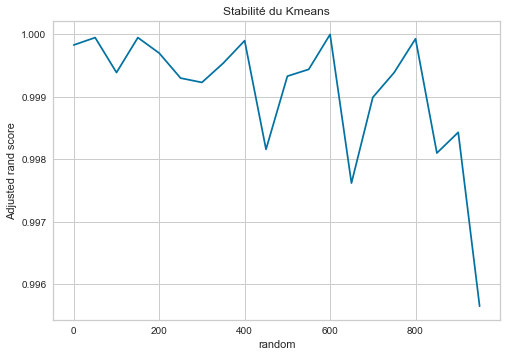

In [222]:
kmeans_stab_random(X_scaled, clusters, 4, 0, 1000, 50, 'rfm')

,customer_unique_id,clusters,clust1,clust2,clust3,clust4,clust5,clust6,clust7
0,0000f46a3911fa3c0805444483337064,0,3,1,1,0,1,0,1
1,0000f6ccb0745a6a4b88665a16c9f078,1,0,0,0,2,1,0,1
2,0004aac84e0df4da2b147fca70cf8255,1,0,0,0,2,0,1,0
3,0005e1862207bf6ccc02e4228effd9a0,0,3,1,1,0,1,0,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,0,3,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...
43956,fffbf87b7a1a6fa8b03f081c5f51a201,1,0,0,0,2,0,1,0
43957,fffcf5a5ff07b0908bd4e2dbc735a684,2,1,2,2,1,2,2,2
43958,fffea47cd6d3cc0a88bd621562a9d061,1,0,0,0,2,0,1,0
43959,ffff371b4d645b6ecea244b27531430a,0,3,1,1,0,1,0,1


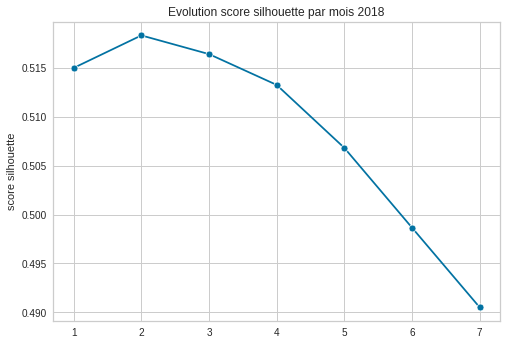

In [ ]:
# calculate kmeans
score_sil = []
for i in range(1, 8):
    day = 31
    if i in [4, 6]:
        day = 30
    elif i == 2:
        day = 28

    date_view = datetime.datetime(2018, i, day)
    data_stab = data_full[['customer_unique_id',
                                 'order_purchase_timestamp', 'totals_items',
                                 'total_price']]
    data_stab = data_stab[pd.to_datetime(
        data_stab['order_purchase_timestamp']) <= date_view]

    data_stab['recency'] = date_view - pd.to_datetime(
        data_stab['order_purchase_timestamp'])
    data_stab['recency'] = data_stab['recency'] / np.timedelta64(1, 'D')
    data_stab = data_stab[['customer_unique_id',
                           'recency', 'totals_items', 'total_price']]
    data_group = data_stab.groupby('customer_unique_id').agg(
        {'recency': 'min', 'totals_items': 'count',
         'total_price': 'sum'}).reset_index()
    # normalisation données
    X = data_group[['recency', 'totals_items', 'total_price']]
    X_scaled = preprocessing.StandardScaler().fit(X).transform(X.values)
    # Kmeans
    random = 42
    kmStab = cluster.KMeans(n_clusters=4,
                            random_state=random).fit(X_scaled)
    clust = kmStab.labels_
    # score silhouette
    sil = metrics.silhouette_score(X_scaled, clust, random_state=42)
    score_sil.append(sil)

    # ajout cluster dans data_resume
    data_group['clust'+str(i)] = clust
    data_resume = data_resume.merge(data_group[['customer_unique_id',
                                                'clust'+str(i)]],
                                    how='left', on='customer_unique_id')


sns.lineplot(x=range(1, 8), y=score_sil, marker='o')
plt.ylabel('score silhouette')
plt.title('Evolution score silhouette par mois 2018')
plt.savefig('fig/kmean_stab_customers_RFM_elbow_silhouette_mois.png',
            bbox_inches='tight')
plt.show
data_resume

Le modèle a besoin une maintenance après 4 mois 

[0.7982127144453194, 0.6765546647693974, 0.5486064514531604, 0.45380810288473994, 0.3705605883350343, 0.3090537395750067, 0.26653762228146166]


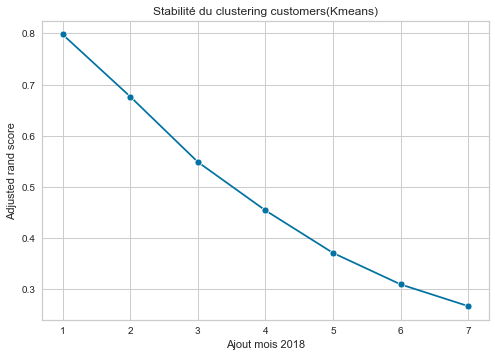

In [225]:
# stabilité Kmeans
data_resume = data_resume.dropna()
ARI = []
for i in range(1, 8):
    ARI.append(metrics.adjusted_rand_score(data_resume['clusters'],
                                           data_resume['clust'+str(i)]))

print(ARI)
sns.lineplot(x=range(1, 8), y=ARI, marker='o')
plt.xlabel('Ajout mois 2018')
plt.ylabel('Adjusted rand score')
plt.title('Stabilité du clustering customers(Kmeans)')
plt.savefig('fig/kmean_stab_customers_RFM_ARI.png', bbox_inches='tight')
plt.show()

gfdgsgbs